<a href="https://colab.research.google.com/github/honestycitra/dl_hw_test/blob/main/d2l_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sumber dari modul d2l: https://d2l.ai/chapter_attention-mechanisms/index.html

In [1]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Attenton Cues

Penyatuan rata-rata (Average pooling) dapaet diperlakukan sebagai rata-rata tertimbang (weighted) dari input, dimana bobotnya sama. Pada Praktiknya, pengumpulan attention dapat dilakukan dengan mengumpulakan nilai menggunakan rata-rata tertimbang, di mana bobot dihitung antara query yang biberikan dan kunci yang berbeda.

In [2]:
import torch
from d2l import torch as d2l

berikut ini fungsi untuk memvisualisasikan bobot attention, didefinisikan dengan fungsi show)heatmaps. Matriks inputnya memiliki bentuk [number of rows for display, number of columns for display, number of queries, number of keys]

In [3]:
#save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

Sebagai demontrasi, berikut ini contoh kasus sederhana di mana bobot attention hanya satu, ketika **query dan key nya sama**;
 ***jika tidak sama*** maka nilainya akan ***nol***. 

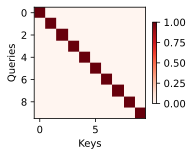

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

**Catatan untuk attention cues:**



*   Perhatian manusia adalah sumber daya yang terbatas, berharga, dan langka.

*   Subjek secara selektif mengarahkan attention menggunakan isyarat *(cues)* non-kehendak dan kehendak. *Cues* non-kehendak didasarkan pada arti-penting dan *cue* kehendak tergantung pada tugas.

*   Mekanisme attention berbeda dari layers yang terhubung penuh (*fully-connected layers*) atau layers penyatuan (*pooling layers*)  karena dimasukkannya isyarat (*cues*) kehendak.

*   Mekanisme attention membiaskan pemilihan nilai (input sensorik) melalui pengumpulan perhatian(*attention pooling*), yang menggabungkan query (isyarat kehendak) dan keys (isyarat non-kehendak). Keys dan nilai dipasangkan.

*   Kita dapat memvisualisasikan bobot attention antara query dan keys.





# 2. Attention Pooling: Nadaraya-Watson Kernel Regression

In [5]:
import torch
from torch import nn
from d2l import torch as d2l

## 2.1. Generating the Dataset

In [6]:
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # Training inputs

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

In [7]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 2.2. Average Pooling

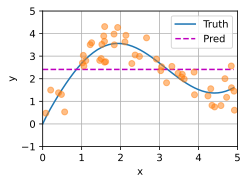

In [8]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 2.3. Nonparametric Attention Pooling

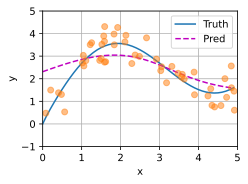

In [9]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

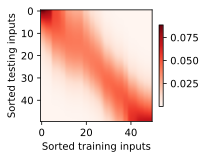

In [10]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 2.4. Parametric Attention Pooling

**Batch Matrix Multiplication**

In [11]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [12]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

**Defining the Model**

In [13]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

**Training**

In [14]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

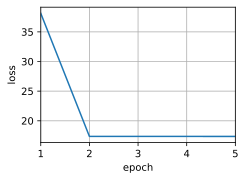

In [15]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

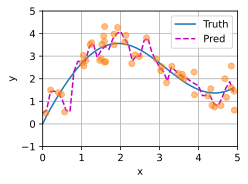

In [16]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

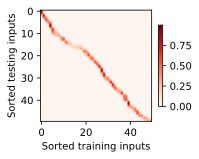

In [17]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 3. Attention Scoring Functions

Memperlakukan eksponen kernel Gaussian sebagai fungsi penilaian attention (fungsi nilai), hasil dari fungsi ini pada dasarnya dimasukkan ke dalam operasi softmax. Hasilnya diperoleh distribusi probabilitas (bobot attention) dari value yang dipasangkan dengan keys. 

Output dari attention pooling hanyalah jumlah bobot dari nilai-nilai yang didasrkan pada bobot attention ini. 

Fungsi attention scoring dinotasikan sebagai ***a***, Gambar ini mengilustrasikan bagaimana output dari attention pooling sapat dihitung sebagai jumlah nilai yang dibobotkan. karena bobot attention adalah distribusi probabilita, jumlah tertimbang (*weighted*) adalah rata-rata tertimbang (*weighted*). 

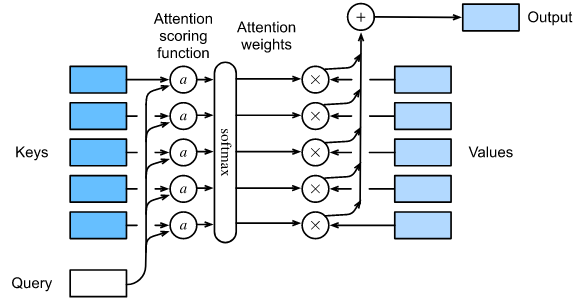

In [18]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 3.1. Masked Softmax Operation

**Operasi** softmax digunakan untuk mengeluatkan distribusi probabilitas ssebagai bobot attention. Dalam beberapa kasus, tidak semua nilai harus dimasukkan ke dalam attention pooling. Misalnya, untuk pemrosesan minibatch yang efisien, beberapa urutan teks diisi dengan token khusus yang tidak memiliki arti.

**Untuk** mendapatkan attention pooling pada token yang bermakna sebagai value, kita dapat menentukan panjang urutan yang valid (dalam jumlah token) untuk menyaring yang ada di luar rentang saat menghitung softmax. Dengan cara ini, kita dapat mengimplementasikan operasi masked softmax dalam fungsi masked_softmax dibawah ini, 

**dimana** disini nilai apapun di luar panjang yang valid disamarkan sebagai nol. 

In [19]:
#save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [20]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5362, 0.4638, 0.0000, 0.0000],
         [0.5320, 0.4680, 0.0000, 0.0000]],

        [[0.2600, 0.2946, 0.4454, 0.0000],
         [0.4142, 0.2099, 0.3760, 0.0000]]])

In [21]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3462, 0.2813, 0.3726, 0.0000]],

        [[0.4826, 0.5174, 0.0000, 0.0000],
         [0.2556, 0.2471, 0.2522, 0.2451]]])

## 3.2. Additive Attention

In [22]:
#save
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [23]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

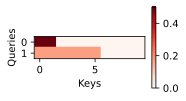

In [24]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 3.3. Scaled Dot-Product Attention

In [25]:
#save
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [26]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

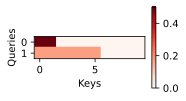

In [27]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

**Catatan untuk Attention Scoring Functions:**



*   Kita dapat menghitung output dari attention pooling sebagai nilai rata-rata tertimbang, di mana pilihan yang berbeda dari attention scoring function mengarah pada perilaku attention pooling yang berbeda.
*   Ketika query dan keys adalah vektor dengan panjang yang berbeda, kita dapat menggunakan fungsi scoring attention tambahan. Jika sama, fungsi scorring attention dot-product yang akan diskalakan lebih efisien secara komputasi. 



# 4. Bahdanau Attention

## 4.1. Model

Saat menjelaskan Bahdanau attention untuk encoder-decoder RNN di bawah ini, kami akan mengikuti notasi yang sama di Bagian 9.7. **Model berbasis attention yang baru sama dengan yang ada di Bagian 9.7 kecuali bahwa variabel konteks *c* di (9.7.3) digantikan oleh *ct* setiap langkah waktu *t'* penguraian kode.** Misalkan ada token ***T*** dalam sekuens input, variabel konteks pada langkah waktu decoding ***t'*** adalah output dari pengumpulan perhatian:

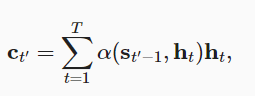

Dimana keadaan tersembunyi (*hidden*) decoder ***S_t'-1***  pada langkah waktu ***t'-1*** adalah queri, dan keadaan tersembunyi cues **h**_t adalah keys and value, dan bobot attention alpha dihitung seperti pada **(3.2)** menggunakan attention scoring function tambahan yang ditentukan oleh **(3.3)**.

Sedikit berbeda dari arsitektur encoder-decoder vanilla RNN pada **Gambar 9.7.2**, arsitektur yang sama dengan perhatian Bahdanau digambarkan pada Gambar dibawah ini:

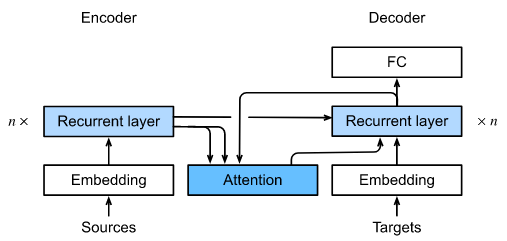

In [29]:
import torch
from torch import nn
from d2l import torch as d2l

## 4.2. Defining the Decoder with Attention

**Untuk** mengimplementasikan encoder-decoder RNN dengan Bahdanau attention, kita hanya perlu mendefinisikan ulang decoder.

**Untuk** memvisualisasikan bobot attention yang dipelajari dengan lebih mudah, kelas AttentionDecoder berikut mendefinisikan dasar interface untuk decoder dengan mekanisme attention.

In [30]:
#save
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

Sekarang mari kita implementasikan dekoder RNN dengan Bahdanau attention di kelas Seq2SeqAttentionDecoder berikut.

**Status decoder diinisialisasi dengan:**

*   status tersembunyi lapisan akhir encoder pada semua langkah waktu (sebagai keys dan nilai attention);
*   keadaan tersembunyi semua layer encoder pada langkah waktu terakhir (untuk menginisialisasi keadaan tersembunyi decoder);
*   panjang valid pembuat encode (untuk mengecualikan token pengisi dalam attention pooling).

Pada setiap langkah waktu decoding, status tersembunyi lapisan akhir decoder pada langkah waktu sebelumnya digunakan sebagai permintaan attention.

Akibatnya, baik output attention dan penyisipan input digabungkan sebagai input dekoder RNN.


In [31]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of `outputs`:
        # (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

Berikut ini, kami menguji decoder yang diimplementasikan dengan Bahdanau attention menggunakan minibatch dari 4 input sekuens dari 7 step waktu. 

In [32]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 4.3. Training

loss 0.019, 7445.9 tokens/sec on cuda:0


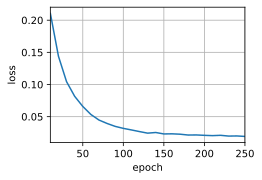

In [33]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [34]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est mouillé .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [35]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

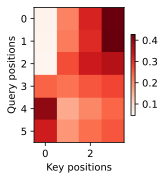

In [36]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

**Catatan untuk  Bahdanau Attention:**



*   Saat memprediksi token, jika semuan token input tidak relevan, encoder-decoder RNN dengan Bahdanau attentionsecara selektif akan mengumpulkan bagian yang berbda dari sekuens input. Hal ini dapat dicapai dengan memperlakukan variabel konteks sebagai outpuy dari attention pooling tambahan. 
*   Dalam encoder-decoder RNN, Bahdanau attention memperlakukan status hidden decoder pada langkah waktu sebelumnya sebagai queri, dan status hidden encoder pada semua langkah waktu sebagai keys dan values. 



# 5. Multi-Head Attention

## 5.1. Model

In [37]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 5.2. Implementation

In [39]:
#save
class MultiHeadAttention(nn.Module):
    """Multi-head attention."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of `queries`, `keys`, or `values`:
        # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
        # Shape of `valid_lens`:
        # (`batch_size`,) or (`batch_size`, no. of queries)
        # After transposing, shape of output `queries`, `keys`, or `values`:
        # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
        # `num_hiddens` / `num_heads`)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for
            # `num_heads` times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of `output`: (`batch_size` * `num_heads`, no. of queries,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # Shape of `output_concat`:
        # (`batch_size`, no. of queries, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [41]:
#save
def transpose_qkv(X, num_heads):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`).
    # Shape of output `X`:
    # (`batch_size`, no. of queries or key-value pairs, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # Shape of output `X`:
    # (`batch_size`, `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # Shape of `output`:
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])


#save
def transpose_output(X, num_heads):
    """Reverse the operation of `transpose_qkv`."""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [42]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [43]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

**Catatan untuk Multi-Head Attention:**

*   Multi-head attention menggabungkan pengetahuan tentang attention pooling yang sama melalui subruang representasi dari queri, keys, dan values yang berbeda.
*   Untuk menghitung beberapa Multi-head attention secara paralel, diperlukan manipulasi tensor yang tepat.



# 6. Self-Attention and Positional Encoding

In [45]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 6.1. Self-Attention

In [46]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [47]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

## 6.3.  Positional Encoding

In [48]:
#save
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

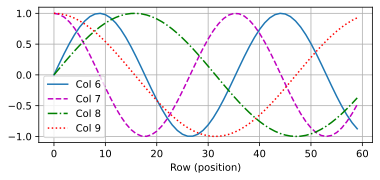

In [49]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

**Absolute Positional Information**

In [50]:
for i in range(8):
    print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


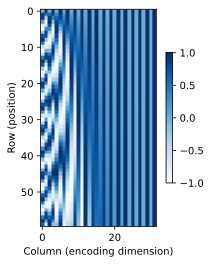

In [51]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

**Catatan untuk Self-Attention and Positional Encoding:**


*   pada self-attention, query, keys, dan values semuanya berasal dari tempat yang sama.
*   Baik CNN dan self-attention menikmati komputasi paralel dan self-attention memiliki panjang jalur maksimum terpendek. Namun, kompleksitas komputasi kuadrat sehubungan dengan panjang urutan membuat self-attention menjadi sangat lambat untuk urutan yang sangat panjang.
*   Untuk menggunakan informasi order sekuens, kita dapat meng-inject informasi posisi absolut atau relatif dengan menambahkan pengkodean posisi ke representasi input.



# 7. Transformer

In [52]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 7.2. Positionwise Feed-Forward Networks

In [53]:
#save
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [54]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.4381, -0.2194, -0.4819, -0.1814,  0.1350, -0.3773, -0.1580,  0.2680],
        [-0.4381, -0.2194, -0.4819, -0.1814,  0.1350, -0.3773, -0.1580,  0.2680],
        [-0.4381, -0.2194, -0.4819, -0.1814,  0.1350, -0.3773, -0.1580,  0.2680]],
       grad_fn=<SelectBackward0>)

## 7.3. Residual Connection and Layer Normalization

In [55]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [56]:
#save
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [57]:
add_norm = AddNorm([3, 4], 0.5) # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 7.4. Encoder

In [58]:
#save
class EncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [59]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [60]:
#save
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [61]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 7.5. Decoder

In [62]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [63]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [64]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 7.6. Training

loss 0.033, 7491.9 tokens/sec on cuda:0


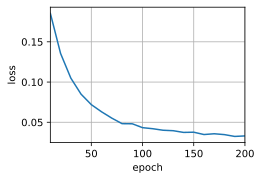

In [65]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [66]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [67]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

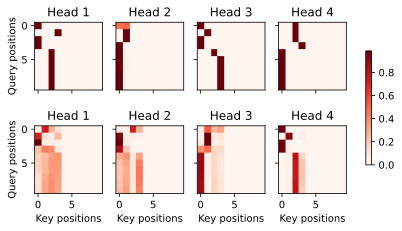

In [68]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [69]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

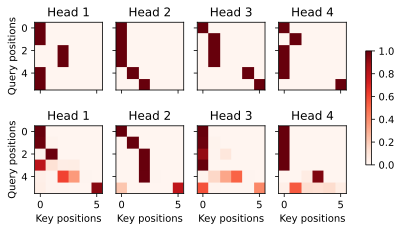

In [70]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

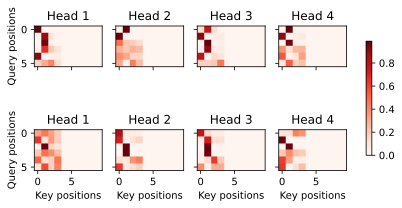

In [71]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

**Catatang Untuk *Transformer*:**



*   *Transformer* adalah turunan dari arsitektur encoder-decoder, meskipun encoder atau decoder dapat digunakan secara individual dalam praktiknya.
*  Pada *transformer*, *multi-head self-attention* digunakan untuk mewakili sekuens input dan sekuens output, meskipun decoder harus mempertahankan properti auto-regresif melalui masked version.
*   Sambungan sisa dan normalisasi layer dalam *transformer* penting untuk melatih very deep model.
*   Jaringan umpan-maju posisi dalam model *transformer* mengubah representasi di semua posisi urutan menggunakan MLP yang sama. 



**End**